In [1]:
library(brms) #predictability: Double hierearchical model
library(MCMCglmm) #HPDinterval
library(dplyr) #%>%
library(lmerTest) #lmer
#library(MuMIn) #r2
#library(merTools) #sim

Warning message:
"le package 'brms' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Rcpp

Warning message:
"le package 'Rcpp' a été compilé avec la version R 4.1.2"
Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attachement du package : 'brms'


L'objet suivant est masqué depuis 'package:stats':

    ar


Warning message:
"le package 'MCMCglmm' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Matrix

Warning message:
"le package 'Matrix' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : coda

Warning message:
"le package 'coda' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : ape

Warning message:
"le package 'ape' a été compilé avec la version R 4.1.2"

Attachement du package : 'MCMCglmm'


L'objet suivant est masqué depuis 'pac

In [2]:
library(parallel)
my.cores = detectCores()-1 #minus 1 to avoid bocking the computer
my.cores

[1] 11

In [3]:
#df[rowSums(is.na(df)) > 0,]

# Behaviorual syndrome

In [13]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
#df = read.csv(file.path(path_,'df_daily_aggregatedHA.csv'), header = TRUE, sep = ",")
df = read.csv(file.path(path_,'df_BS.csv'), header = TRUE, sep = ",")

df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID)
df$TrackingSystemID = as.factor(df$TrackingSystemID)
df$level = as.factor(df$level) 
df$FoodPenID = as.factor(df$FoodPenID) 
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)

#scale: mean-centering of the environmental variable so that intercepts reflect average values for the HenID and ind. 
#df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)

#setting reference group
contrasts(df$Treatment)
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)

contrasts(df$CLASS)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "LEXP"))
contrasts(df$CLASS)
print(dim(df))
summary(df)

df$WentinWG = as.integer(df$WentinWG)
df$Sleeping_NotUppest = as.integer(df$Sleeping_NotUppest)

df$food_reactivity_index_cst = df$food_reactivity_index+1.01
df$KBFInterp = df$KBF_interp
df$weightInterp = df$weight_interp


dim(df)
df_time = df[df$BS_type=='time',]
dim(df_time)

df_LP2 = df[df$BS_type=='LP2',]
dim(df_LP2)

df_LP10 = df[df$BS_type=='LP10',]
dim(df_LP10)

df_cold = df[df$BS_type=='cold',]
dim(df_cold)

df_vacc = df[df$BS_type=='TypicalVaccinationDay',]
dim(df_vacc)

df_AC = df[df$across_context==1,]
dim(df_AC)

,TRAN
OFH,0
TRAN,1


,OFH
TRAN,0
OFH,1


,MEXP,NewAfterEpi,REXP
LEXP,0,0,0
MEXP,1,0,0
NewAfterEpi,0,1,0
REXP,0,0,1


,MEXP,NewAfterEpi,REXP
LEXP,0,0,0
MEXP,1,0,0
NewAfterEpi,0,1,0
REXP,0,0,1


[1] 4811   22


             TrackingSystemID        level           DOA             DIB       
 TrackingSystem 10-12:1848    2021-01-17: 156   Min.   :179.0   Min.   : 61.0  
 TrackingSystem 3-5  :1783    2021-04-18: 156   1st Qu.:216.0   1st Qu.: 98.0  
 TrackingSystem 8-9  :1180    2021-01-24: 155   Median :284.0   Median :166.0  
                              2021-05-07: 155   Mean   :285.4   Mean   :167.4  
                              2021-05-23: 155   3rd Qu.:340.0   3rd Qu.:222.0  
                              2021-01-05: 154   Max.   :410.0   Max.   :292.0  
                              (Other)   :3880                                  
         FoodPenID      BS_type          Treatment           CLASS     
 FoodPenID1-4 :1144   Length:4811        TRAN:2413   LEXP       : 866  
 FoodPenID5-8 :1206   Class :character   OFH :2398   MEXP       :1104  
 FoodPenID9-12:2461   Mode  :character               NewAfterEpi:1480  
                                                     REXP       :1361  


[1] 4811   25

[1] 3143   25

[1] 457  25

[1] 444  25

[1] 307  25

[1] 460  25

[1] 603  25

# Multivariate models with correlated multilevel structure

#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula = scale(food_related_behavior_final_inv_cst) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+ (1|a|HenID), 
          data=df_time, family = gaussian())

#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula = Sleeping_NotUppest ~ Treatment + scale(weight_interp)+scale(KBF_interp) + (1|a|HenID), 
          data=df_time, family = bernoulli())

In [15]:
#not scaling, keeping most possible original scale
FA = bf(food_reactivity_index_cst ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+ (1|a|HenID),
       family=Gamma(link='log'))
VTD = bf(vertical_travel_distance_fulllight_perinsideh ~ Treatment + scale(weightInterp)+scale(KBFInterp)+scale(DIB) +(1|a|HenID),
        family=gaussian)
TM = bf(mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1|a|HenID),
       family=Gamma(link='log'))
SD = bf(Sleeping_NotUppest ~ Treatment + scale(weightInterp)+scale(KBFInterp) + scale(DIB) + (1|a|HenID), 
        family = bernoulli()) 
#by default, the first category will serve as the reference (https://discourse.mc-stan.org/t/example-with-family-multinomial/8707/3)
#so latency_1_Zone_15mn_3h will be left out and latency_1_Zone_15mn_3hOPP will be shown
#WG = bf(latency_1_Zone_15mn_3h_bind | trials(size) ~ Treatment +scale(DIB)+scale(weight_interp)+scale(KBF_interp)+(1|a|HenID), 
#        family = multinomial()) 
WG = bf(WentinWG ~ Treatment+scale(weightInterp)+scale(KBFInterp) + scale(DIB)+(1|a|HenID), 
        family = bernoulli()) 
#NV = bf(nbr_visit_Z4_Morning_more60sec ~ Treatment +scale(weight_interp) + scale(DIB) + scale(KBF_interp) +(1|a|HenID),
#        family=poisson)
Multi_DHGLM = brm(FA + VTD + TM + SD + WG +
                    set_rescor(FALSE),
                    data = df,
                    iter = 20000, warmup = 15000, thin = 4,
                    chains = 4, cores =my.cores, seed = 12345
                    )

#save model (from: https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/horoscopes-insights.html#save-your-model-fits)
save(Multi_DHGLM, file = "Multi_DHGLM_allvar_moreit_withoutWG.rda")
#load("Multi_DHGLM_allvar.rda") #do not put modelreload = load("Multi_DHGLM_allvar.rda")

summary(Multi_DHGLM)
#cor(scaleVTD_Intercept,mulatency1Zone15mn3hOPP_latency1Zone15mn3hbind_Intercept)  : the more you move vertically, the more
#latency1Zone15mn3hOPP is high, i.e. the more you go in the WG earlier

Compiling Stan program...

Start sampling



 Family: MV(gamma, gaussian, gamma, bernoulli, bernoulli) 
  Links: mu = log; shape = identity
         mu = identity; sigma = identity
         mu = log; shape = identity
         mu = logit
         mu = logit 
Formula: food_reactivity_index_cst ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1 | a | HenID) 
         vertical_travel_distance_fulllight_perinsideh ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1 | a | HenID) 
         mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1 | a | HenID) 
         Sleeping_NotUppest ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1 | a | HenID) 
         WentinWG ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + (1 | a | HenID) 
   Data: df (Number of observations: 4811) 
  Draws: 4 chains, each with iter = 5000; warmup = 3750; thin = 4;
         total post-warmup draws = 1250

Group-Level Effects: 
~HenID (Nu

In [16]:
#conditional_effects(Multi_DHGLM)

In [17]:
Multi_DHGLM = add_criterion(Multi_DHGLM, criterion=c('waic','loo'), file=file.path(path_,'RMS_BS_pred_allvar_moreit'))
#pairs(Multi_DHGLM)

Warning message:
"
409 (8.5%) p_waic estimates greater than 0.4. We recommend trying loo instead."
Warning message:
"Found 1 observations with a pareto_k > 0.7 in model 'Multi_DHGLM'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. "


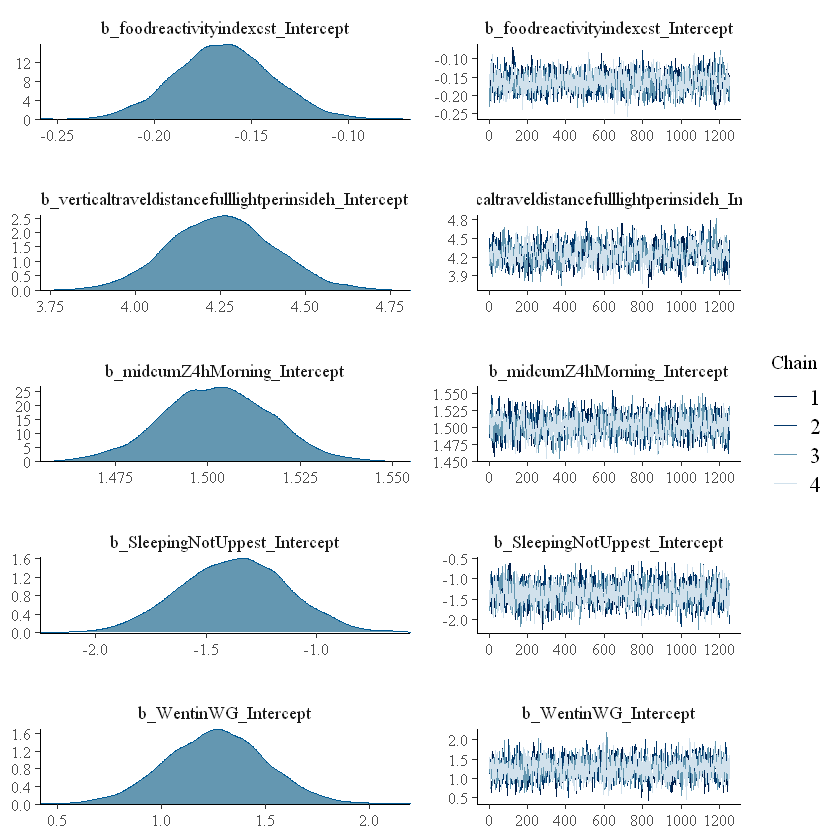

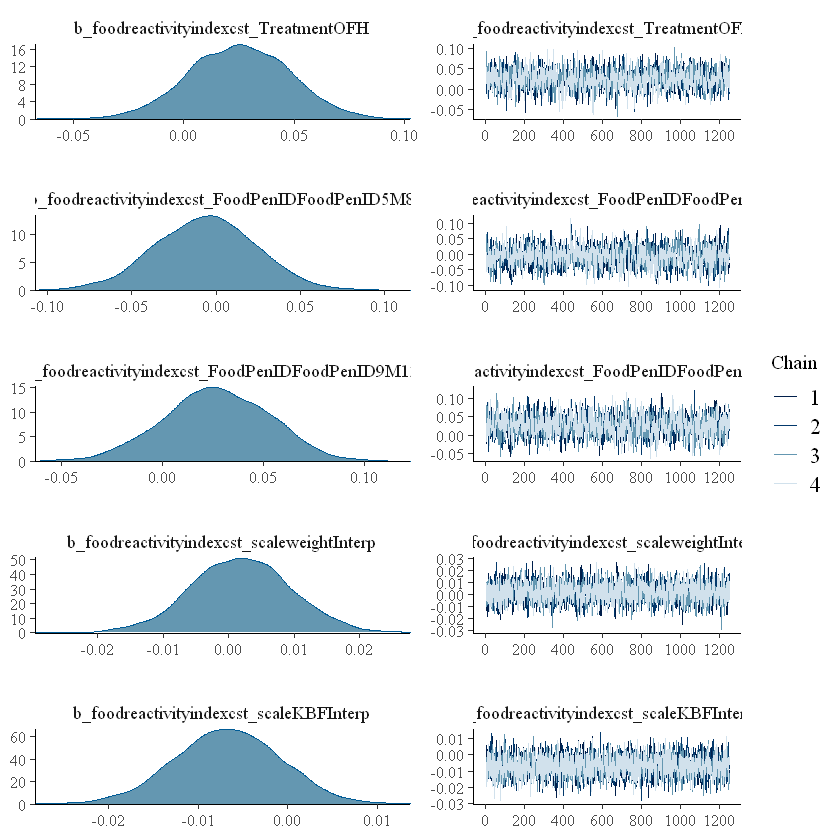

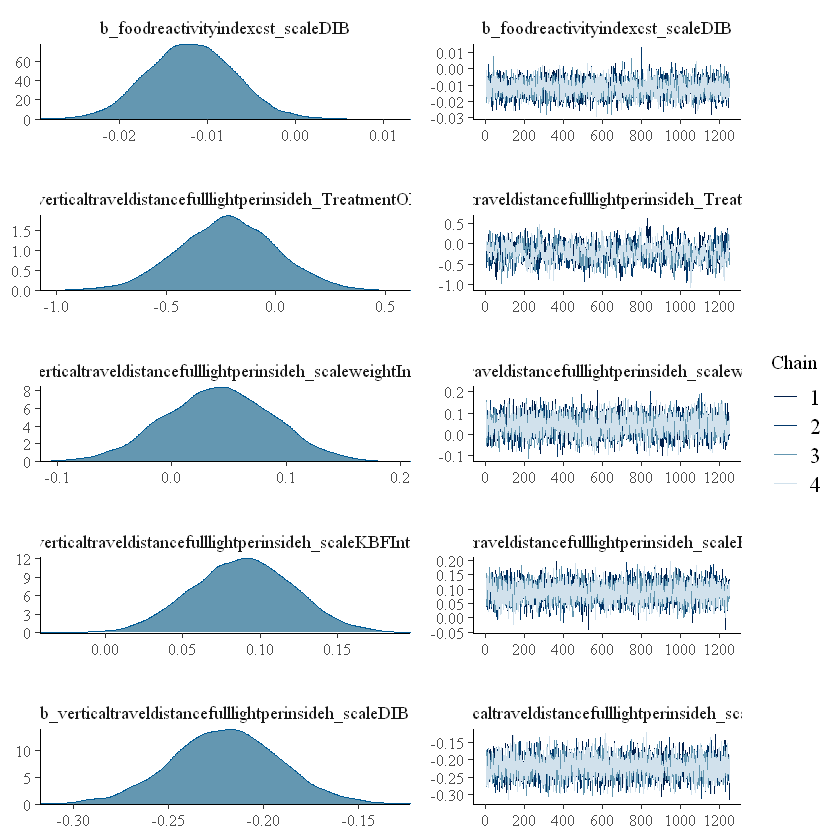

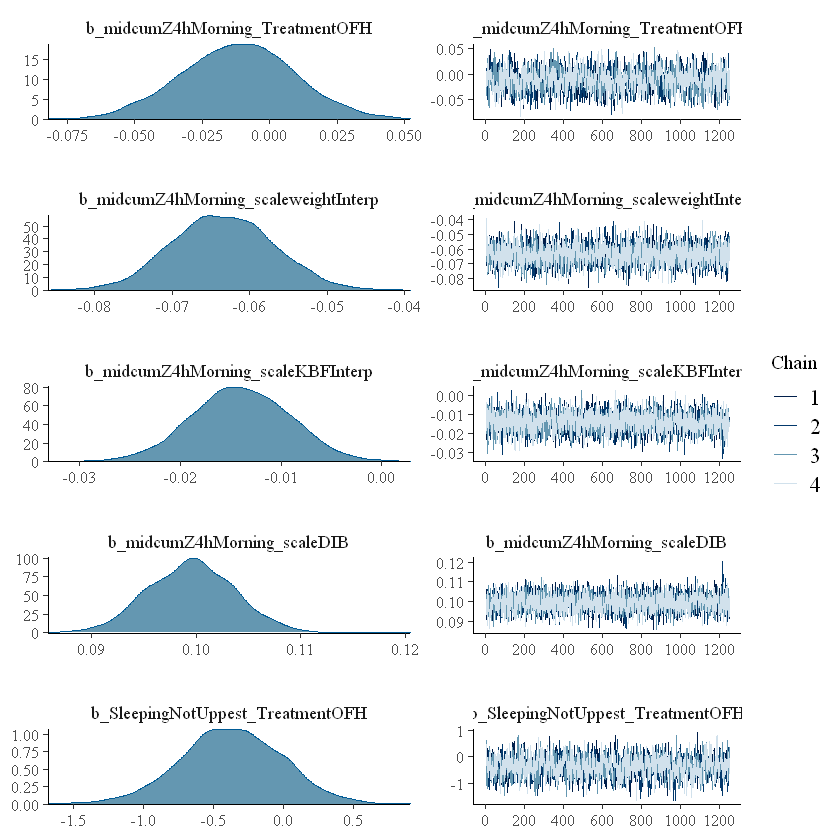

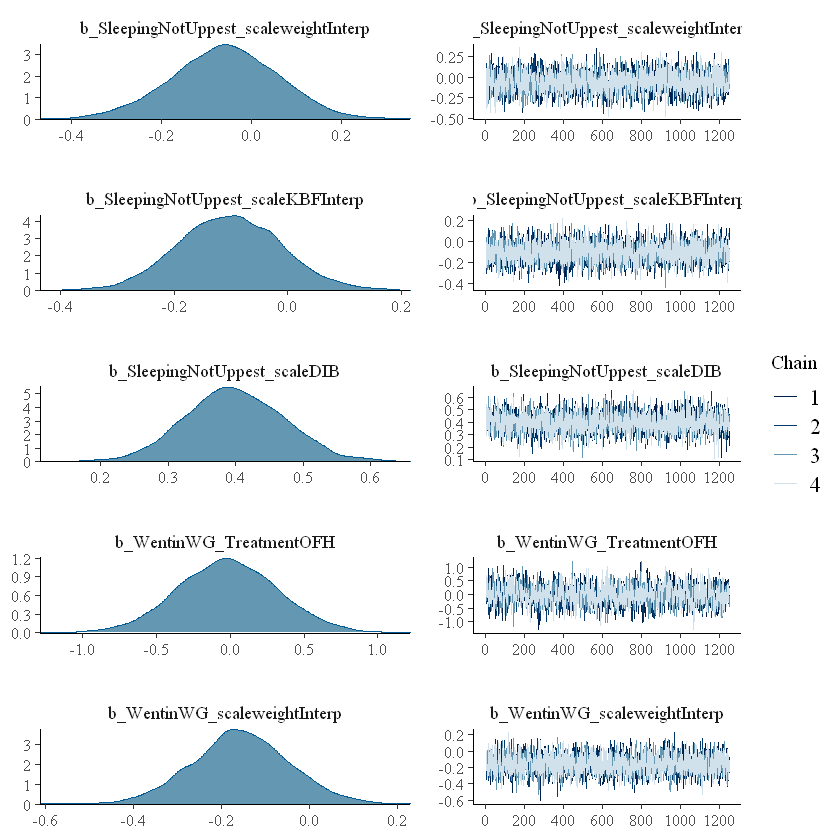

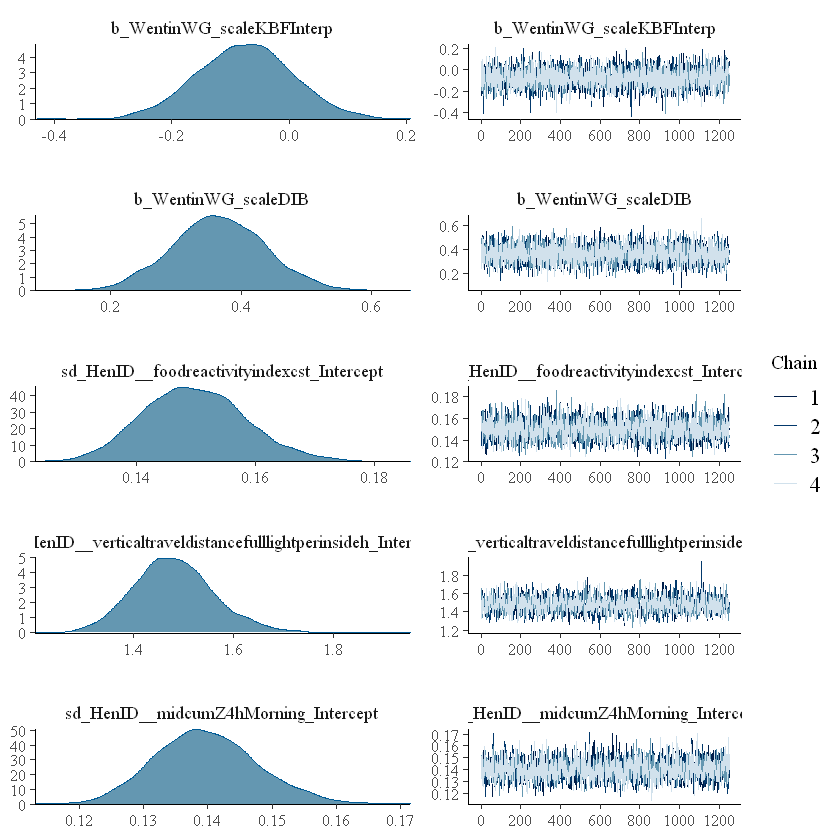

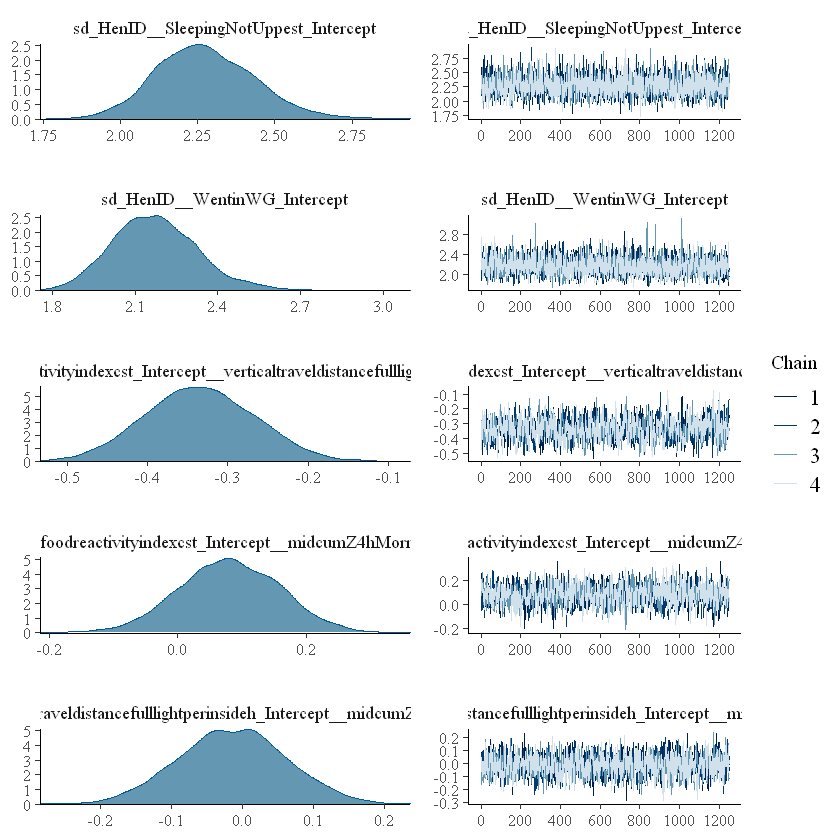

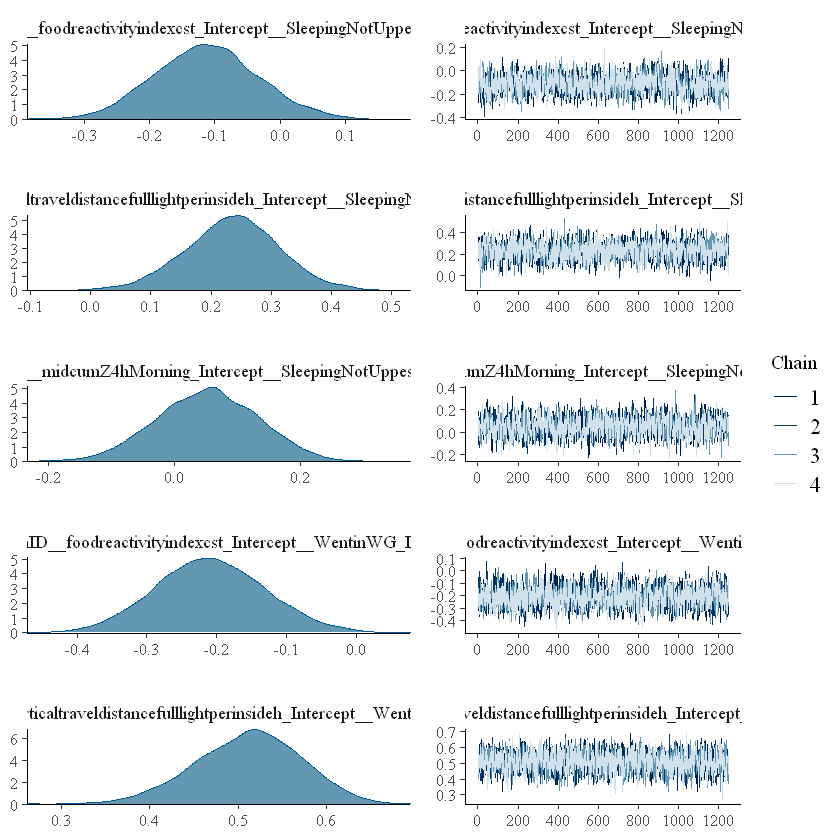

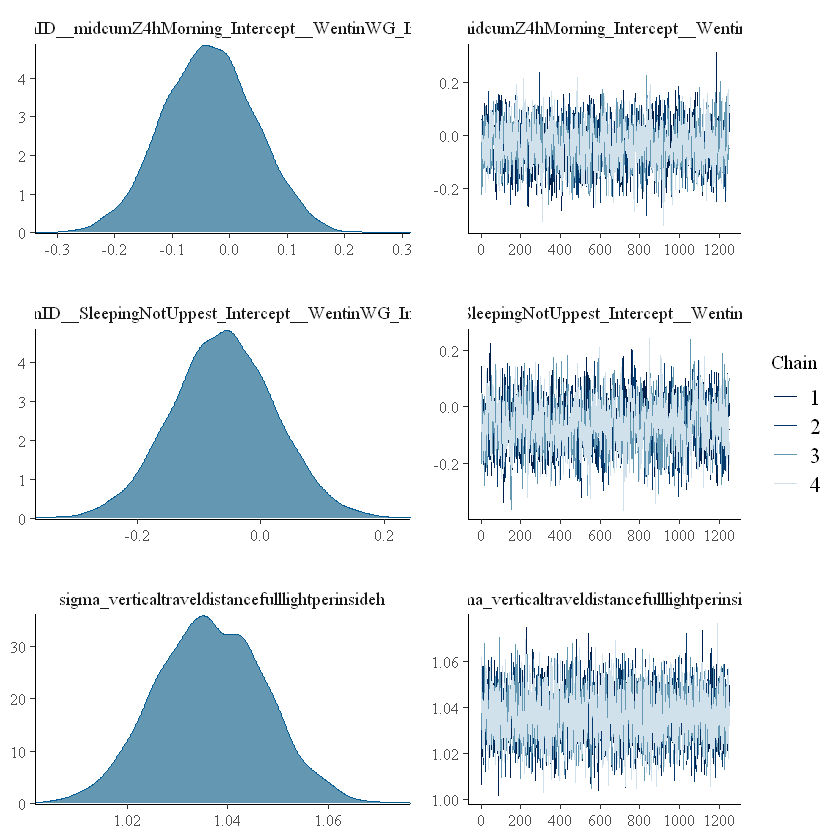

In [18]:
plot(Multi_DHGLM)
#head(get_variables(modelPred),10)

In [19]:
prior_summary(Multi_DHGLM)

#coefficient of variation in predictability” (CVP)
#log.norm.res = exp(posterior_samples(Multi_DHGLM)$"sd_HenID__sigma_Intercept"^2)
#CVP = sqrt(log.norm.res-1)
#mean(CVP);HPDinterval(as.mcmc(CVP),0.95)

#all data, sd in python
#extract samples (draw) from the posterior distribution, including all variables
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
colnames(posterior_samples(Multi_DHGLM))[1:30]
df_pred = as_draws(Multi_DHGLM)
write.csv(df_pred, file.path(path_,'BRMS_BS_pred_allvar_moreit.csv'), row.names = TRUE)

#only meand and CI from R
df_pred = posterior_samples(Multi_DHGLM)
dim(df_pred)
df_mean = colMeans(df_pred)
df_CI = HPDinterval(as.mcmc(df_pred))
dim(df_CI)
write.csv(df_CI, file.path(path_,'df_CI_BRMS_BS_pred_allvar_moreit.csv'), row.names = TRUE)
write.csv(df_mean, file.path(path_,'df_mean_BRMS_BS_pred_allvar_moreit.csv'), row.names = TRUE)

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,foodreactivityindexcst,,,,default
,b,FoodPenIDFoodPenID5M8,,foodreactivityindexcst,,,,default
,b,FoodPenIDFoodPenID9M12,,foodreactivityindexcst,,,,default
,b,scaleDIB,,foodreactivityindexcst,,,,default
,b,scaleKBFInterp,,foodreactivityindexcst,,,,default
,b,scaleweightInterp,,foodreactivityindexcst,,,,default
,b,TreatmentOFH,,foodreactivityindexcst,,,,default
,b,,,midcumZ4hMorning,,,,default
,b,scaleDIB,,midcumZ4hMorning,,,,default


Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] "b_foodreactivityindexcst_Intercept"                           
 [2] "b_verticaltraveldistancefulllightperinsideh_Intercept"        
 [3] "b_midcumZ4hMorning_Intercept"                                 
 [4] "b_SleepingNotUppest_Intercept"                                
 [5] "b_WentinWG_Intercept"                                         
 [6] "b_foodreactivityindexcst_TreatmentOFH"                        
 [7] "b_foodreactivityindexcst_FoodPenIDFoodPenID5M8"               
 [8] "b_foodreactivityindexcst_FoodPenIDFoodPenID9M12"              
 [9] "b_foodreactivityindexcst_scaleweightInterp"                   
[10] "b_foodreactivityindexcst_scaleKBFInterp"                      
[11] "b_foodreactivityindexcst_scaleDIB"                            
[12] "b_verticaltraveldistancefulllightperinsideh_TreatmentOFH"     
[13] "b_verticaltraveldistancefulllightperinsideh_scaleweightInterp"
[14] "b_verticaltraveldistancefulllightperinsideh_scaleKBFInterp"   
[15] "b_verticaltraveldistancefulllightperinsideh_scaleDIB"         
[16] "b_midcumZ4hMorning_TreatmentOFH"                              
[17] "b_midcumZ4hMorning_scaleweightInterp"                         
[18] "b_midcumZ4hMorning_scaleKBFInterp"                            
[19] "b_midcumZ4hMorning_scaleDIB"                                  
[20] "b_SleepingNotUppest_TreatmentOFH"                             
[21] "b_SleepingNotUppest_scaleweightInterp"                        
[22] "b_SleepingNotUppest_scaleKBFInterp"                           
[23] "b_SleepingNotUppest_scaleDIB"                                 
[24] "b_WentinWG_TreatmentOFH"                                      
[25] "b_WentinWG_scaleweightInterp"                                 
[26] "b_WentinWG_scaleKBFInterp"                                    
[27] "b_WentinWG_scaleDIB"                                          
[28] "sd_HenID__foodreactivityindexcst_Intercept"                   
[29] "sd_HenID__verticaltraveldistancefulllightperinsideh_Intercept"
[30] "sd_HenID__midcumZ4hMorning_Intercept"

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 5000  996

[1] 996   2

In [20]:
dim(df_CI)
dim(df_alltime)

[1] 996   2

ERROR: Error in eval(expr, envir, enclos): objet 'df_alltime' introuvable


In [21]:
#mean population-level 
fixef(Multi_DHGLM)

,Estimate,Est.Error,Q2.5,Q97.5
foodreactivityindexcst_Intercept,-0.164280456,0.024901336,-0.21255801,-0.115791500
verticaltraveldistancefulllightperinsideh_Intercept,4.253126496,0.153500305,3.95444074,4.557216324
midcumZ4hMorning_Intercept,1.502409751,0.014488954,1.47365481,1.530306226
SleepingNotUppest_Intercept,-1.372606107,0.244263412,-1.84726188,-0.899984323
WentinWG_Intercept,1.262402294,0.238452469,0.79423786,1.729869210
foodreactivityindexcst_TreatmentOFH,0.025076068,0.023068564,-0.02040131,0.069378026
foodreactivityindexcst_FoodPenIDFoodPenID5M8,-0.006196077,0.030073622,-0.06589319,0.052041410
foodreactivityindexcst_FoodPenIDFoodPenID9M12,0.026962834,0.026641294,-0.02615459,0.077388228
foodreactivityindexcst_scaleweightInterp,0.001946252,0.007621176,-0.01329036,0.017042376
foodreactivityindexcst_scaleKBFInterp,-0.006702280,0.005907701,-0.01836329,0.004534744


In [22]:
#TODO: add predictability and KBF

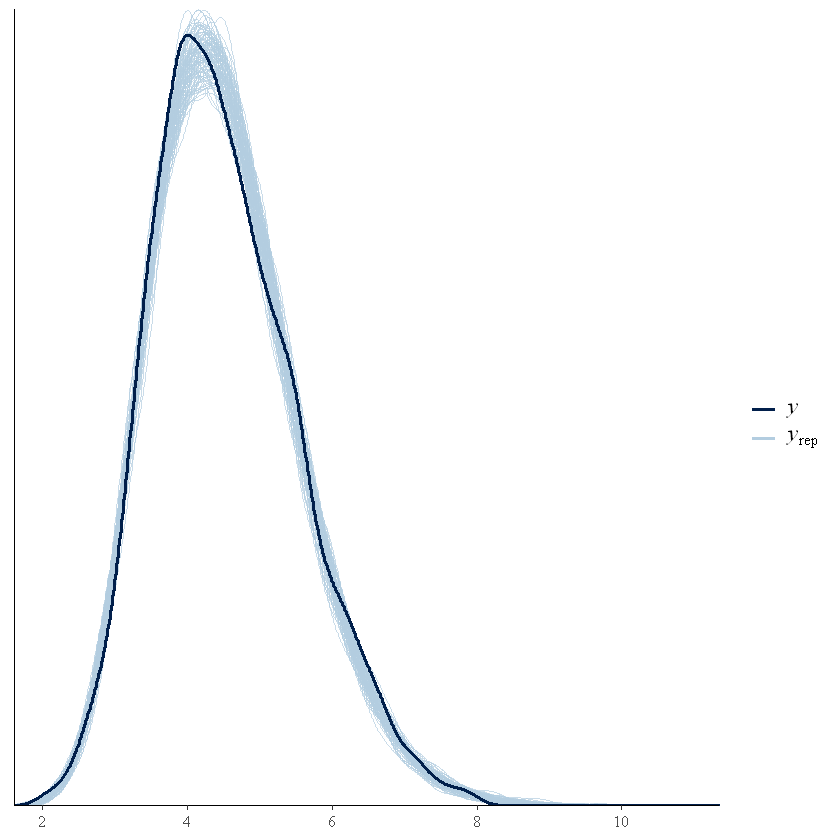

In [23]:
pp_check(Multi_DHGLM, resp='midcumZ4hMorning',ndraws = 100)

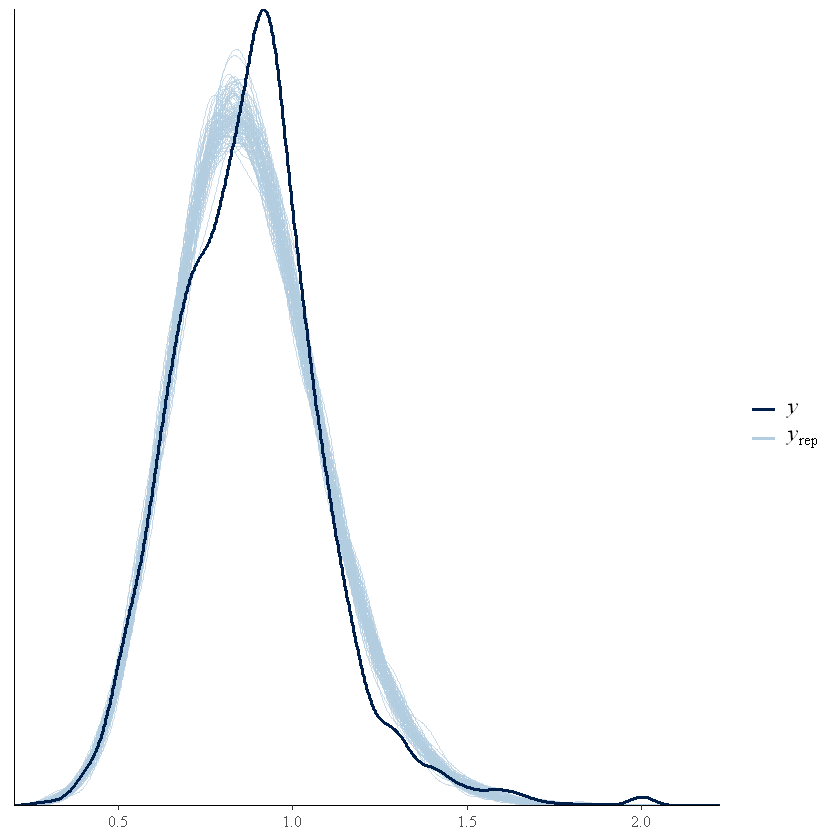

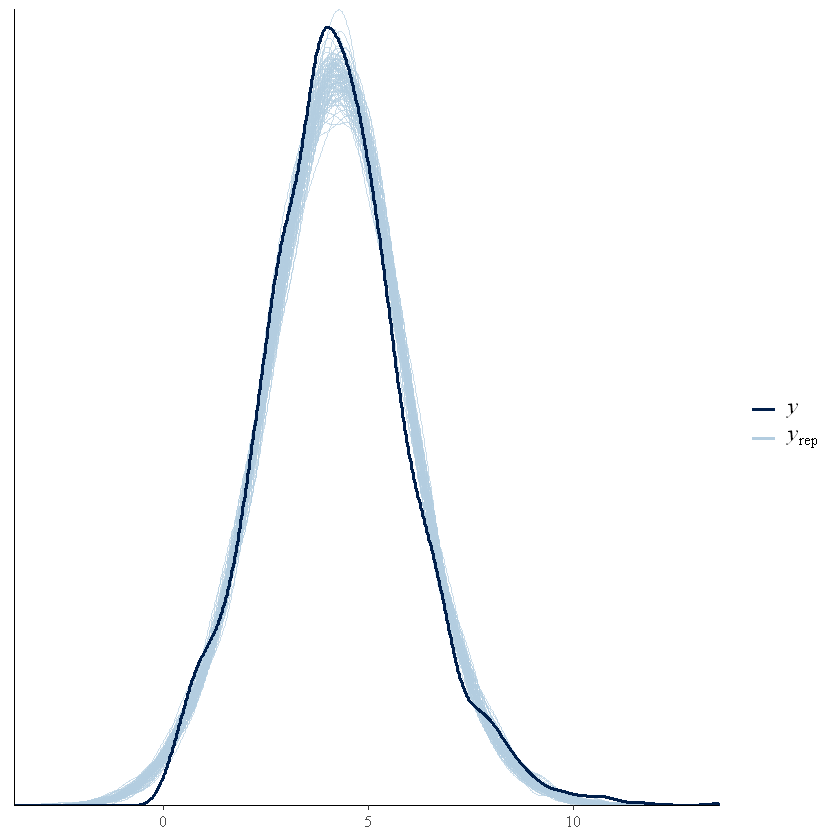

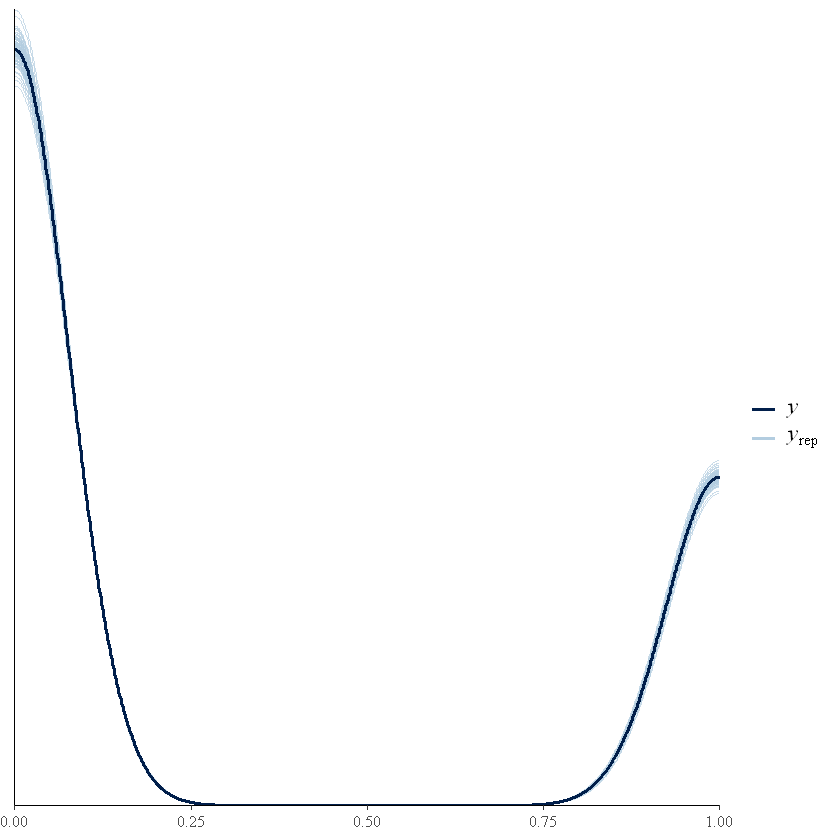

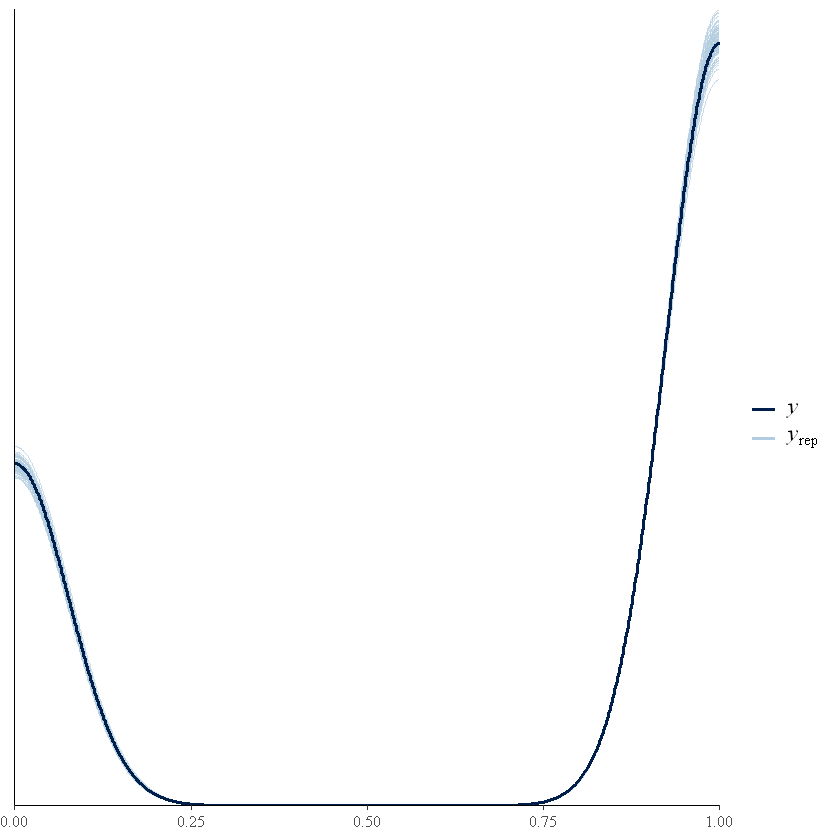

In [25]:
pp_check(Multi_DHGLM, resp='foodreactivityindexcst',ndraws = 100)
pp_check(Multi_DHGLM, resp='verticaltraveldistancefulllightperinsideh',ndraws = 100)
pp_check(Multi_DHGLM, resp='SleepingNotUppest',ndraws = 100)
pp_check(Multi_DHGLM, resp='WentinWG',ndraws = 100)

In [ ]:
#pp_check(Multi_DHGLM, resp='latency1Zone15mn3hbind',ndraws = 100) #'pp_check' is not implemented for this family.
#TODO

In [26]:
#pp_check(Multi_DHGLM, resp='nbrvisitZ4Morningmore60sec',ndraws = 100)

In [27]:
print(Multi_DHGLM$criteria$waic)
#approximative leave-one-out cross validation
print(Multi_DHGLM$criteria$loo)


Computed from 5000 by 4811 log-likelihood matrix

          Estimate    SE
elpd_waic -14509.1 146.9
p_waic       843.8  14.4
waic       29018.1 293.8

409 (8.5%) p_waic estimates greater than 0.4. We recommend trying loo instead. 

Computed from 5000 by 4811 log-likelihood matrix

         Estimate    SE
elpd_loo -14514.6 147.0
p_loo       849.4  14.6
looic     29029.3 294.0
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     4780  99.4%   396       
 (0.5, 0.7]   (ok)         30   0.6%   271       
   (0.7, 1]   (bad)         1   0.0%   71        
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.


In [28]:
#load("Multi_DHGLM_allvar.rda")


Computed from 5000 by 4811 log-likelihood matrix

         Estimate    SE
elpd_loo -14514.6 147.0
p_loo       849.4  14.6
looic     29029.3 294.0
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     4780  99.4%   396       
 (0.5, 0.7]   (ok)         30   0.6%   271       
   (0.7, 1]   (bad)         1   0.0%   71        
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.

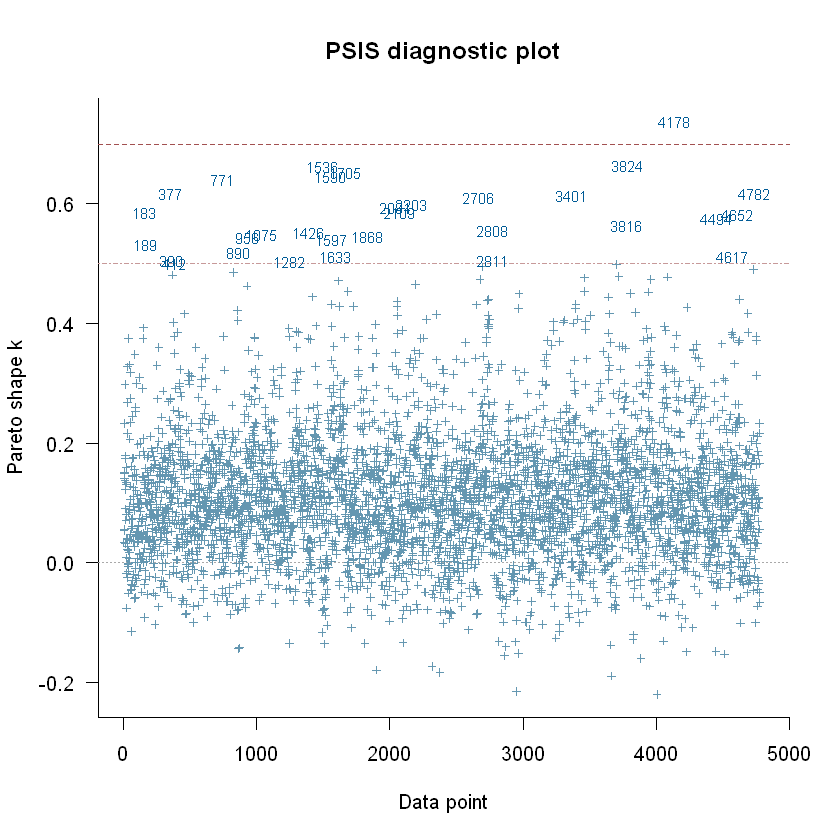

In [29]:
#check highly influential observations
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-moment-matching.html
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-example.html
#"If we had a well-specified model we would expect the estimated effective number of parameters (p_loo) to be smaller than or 
#similar to the total number of parameters in the model."
loo2 = loo(Multi_DHGLM, moment_match = TRUE)
loo2
plot(loo2, label_points = TRUE)

In [34]:
colnames(posterior_samples(Multi_DHGLM))[1:60]

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] "b_foodreactivityindexcst_Intercept"                                                              
 [2] "b_verticaltraveldistancefulllightperinsideh_Intercept"                                           
 [3] "b_midcumZ4hMorning_Intercept"                                                                    
 [4] "b_SleepingNotUppest_Intercept"                                                                   
 [5] "b_WentinWG_Intercept"                                                                            
 [6] "b_foodreactivityindexcst_TreatmentOFH"                                                           
 [7] "b_foodreactivityindexcst_FoodPenIDFoodPenID5M8"                                                  
 [8] "b_foodreactivityindexcst_FoodPenIDFoodPenID9M12"                                                 
 [9] "b_foodreactivityindexcst_scaleweightInterp"                                                      
[10] "b_foodreactivityindexcst_scaleKBFInterp"                                                         
[11] "b_foodreactivityindexcst_scaleDIB"                                                               
[12] "b_verticaltraveldistancefulllightperinsideh_TreatmentOFH"                                        
[13] "b_verticaltraveldistancefulllightperinsideh_scaleweightInterp"                                   
[14] "b_verticaltraveldistancefulllightperinsideh_scaleKBFInterp"                                      
[15] "b_verticaltraveldistancefulllightperinsideh_scaleDIB"                                            
[16] "b_midcumZ4hMorning_TreatmentOFH"                                                                 
[17] "b_midcumZ4hMorning_scaleweightInterp"                                                            
[18] "b_midcumZ4hMorning_scaleKBFInterp"                                                               
[19] "b_midcumZ4hMorning_scaleDIB"                                                                     
[20] "b_SleepingNotUppest_TreatmentOFH"                                                                
[21] "b_SleepingNotUppest_scaleweightInterp"                                                           
[22] "b_SleepingNotUppest_scaleKBFInterp"                                                              
[23] "b_SleepingNotUppest_scaleDIB"                                                                    
[24] "b_WentinWG_TreatmentOFH"                                                                         
[25] "b_WentinWG_scaleweightInterp"                                                                    
[26] "b_WentinWG_scaleKBFInterp"                                                                       
[27] "b_WentinWG_scaleDIB"                                                                             
[28] "sd_HenID__foodreactivityindexcst_Intercept"                                                      
[29] "sd_HenID__verticaltraveldistancefulllightperinsideh_Intercept"                                   
[30] "sd_HenID__midcumZ4hMorning_Intercept"                                                            
[31] "sd_HenID__SleepingNotUppest_Intercept"                                                           
[32] "sd_HenID__WentinWG_Intercept"                                                                    
[33] "cor_HenID__foodreactivityindexcst_Intercept__verticaltraveldistancefulllightperinsideh_Intercept"
[34] "cor_HenID__foodreactivityindexcst_Intercept__midcumZ4hMorning_Intercept"                         
[35] "cor_HenID__verticaltraveldistancefulllightperinsideh_Intercept__midcumZ4hMorning_Intercept"      
[36] "cor_HenID__foodreactivityindexcst_Intercept__SleepingNotUppest_Intercept"                        
[37] "cor_HenID__verticaltraveldistancefulllightperinsideh_Intercept__SleepingNotUppest_Intercept"     
[38] "cor_HenID__midcumZ4hMorning_Intercept__SleepingNotUppest_Intercept"                              
[39] "cor_HenID__foodreactivityindexcst_Intercept

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,-0.4737393,-0.20908


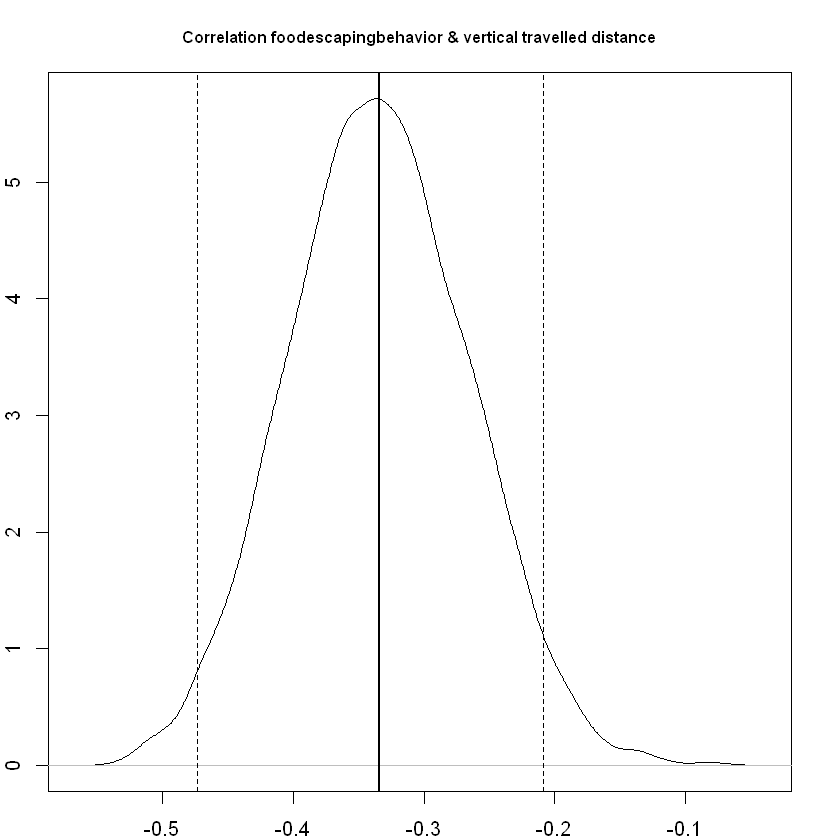

In [38]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__foodreactivityindexcst_Intercept__verticaltraveldistancefulllightperinsideh_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation foodescapingbehavior & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,0.07941628,0.3853283


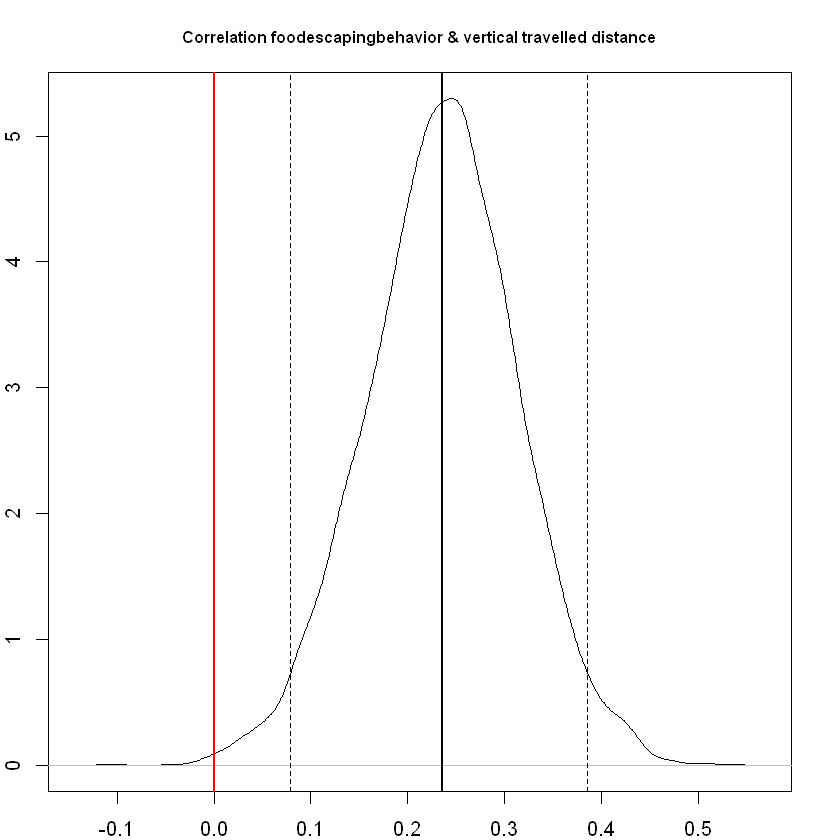

In [35]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__verticaltraveldistancefulllightperinsideh_Intercept__SleepingNotUppest_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation foodescapingbehavior & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,-0.3586534,-0.05337055


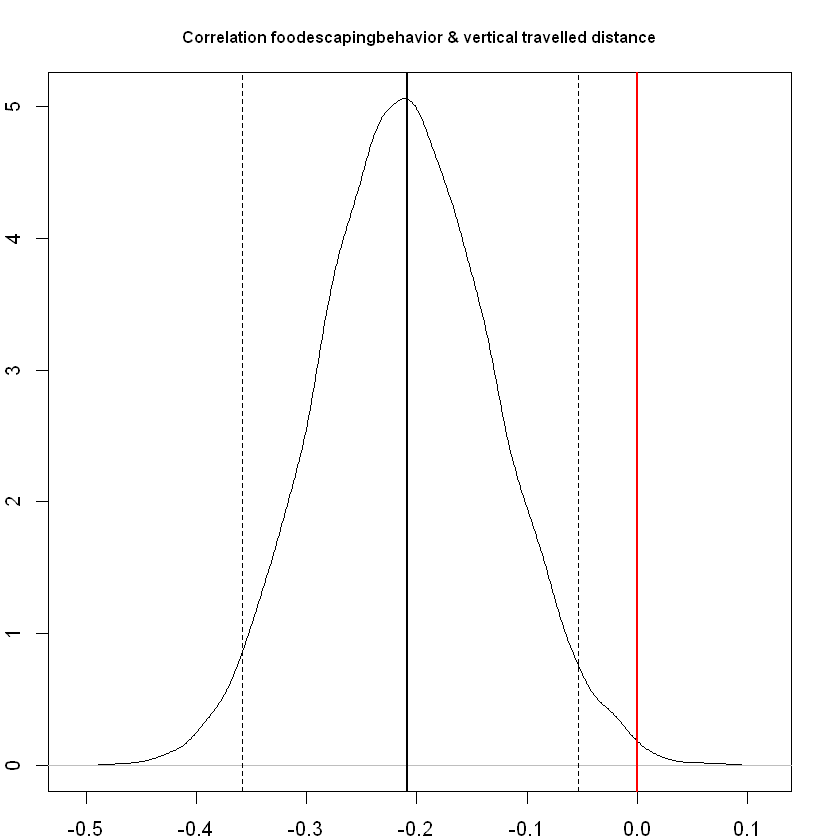

In [36]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__foodreactivityindexcst_Intercept__WentinWG_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation foodescapingbehavior & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,0.3923471,0.6214356


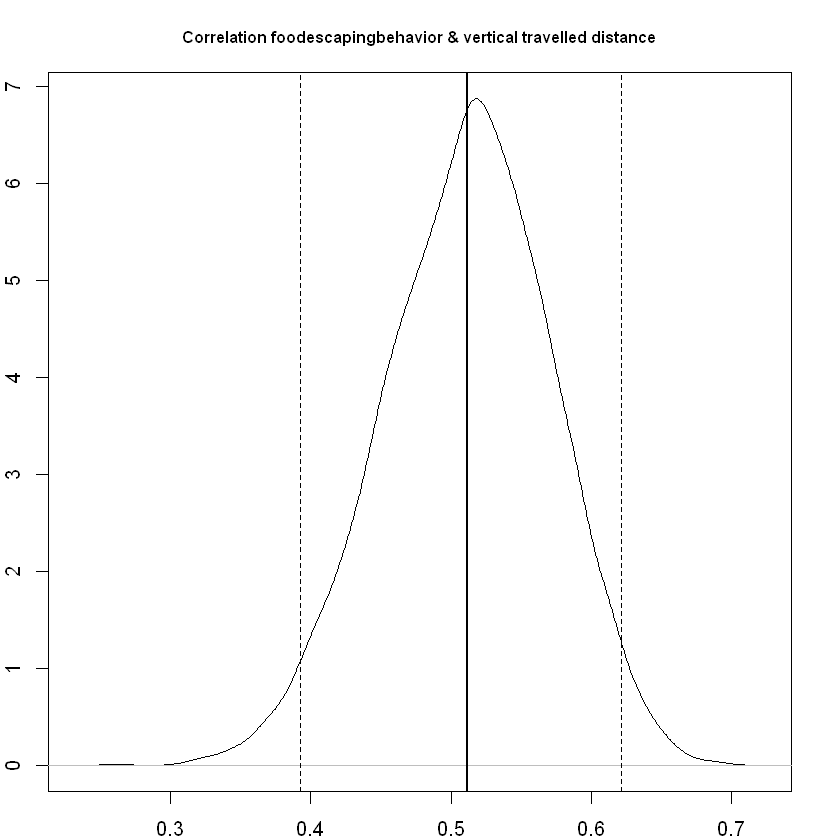

In [37]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__verticaltraveldistancefulllightperinsideh_Intercept__WentinWG_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation foodescapingbehavior & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))